# 背景与工具
k-Means 和 k-NN 这两个名字很像的算法很容易被混淆，尽管它们的用途不同、遵循的学习范式也不同。前者其实是一个聚类算法，k-Means 在无监督的设定下在数据集中寻找 k 个簇。它通过迭代地放置/移动 k 个簇中心，并将最近的样本点分配到簇中，同时优化不同簇之间的分离度。后者是一个分类器，在最基本的概念形式中，它并不会真正针对给定数据拟合模型，而是对一个未见过的数据点，在整个数据集中按照某种距离度量寻找最近的 k 个邻居，并将其中多数类别作为预测类别。在具体实现中，会使用其它技术对数据进行一定的结构化，使得寻找最近点的操作只需要在数据集的一部分内进行。不过它仍可视为监督式的，因为在进行这些预处理时，它会使用到数据点的类别标签。

在本次作业中，你将使用 SciKitLearn 提供的一个简化版 MNIST 手写数字数据集（sklearn.datasets.digits），并结合 UMAP 对其进行检查和改造，计算每个样本与各类别均值之间的余弦相似度，随后分别使用 k-Means 进行聚类以及使用 k-NN 分类器进行分类，并运行不同的评估工具。目的在于让你体验一次维度约简工具（例如 UMAP）的使用、完成一次 Python/Numpy 的矩阵乘法、理解 SciKitLearn 提供的混淆矩阵和评估报告中的不同元素，以及思考在聚类任务中如何进行评估（这不像分类任务那样天然，因为分类的答案要么对要么错）。


# 练习 1：入门


### 练习 1.1
请先通过 ["Lab 0: Python intro"](https://canvas.education.lu.se/courses/32297/pages/lab-0-python-intro) 确保所有必要的基础工具都已正确运行。如果你的环境中尚未安装 UMAP，请安装它（例如使用 ```pip install umap-learn```，可参考 https://umap-learn.readthedocs.io/en/latest/basic_usage.html 获取一些提示）。


In [1]:
# Install with pip install scikit-learn pandas seaborn umap-learn IProgress
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
from collections import Counter # For majority counting, but is not strictly necessary
import matplotlib.pyplot as plt 
import numpy as np

import seaborn as sns
import pandas as pd
import umap

### 练习 1.2
从 SciKitLearn 提供的数据集中加载 digits 数据集。[Dennis Medved 的 Python 教程](Python_introduction.ipynb) 可以为本部分以及后续任务提供代码片段和灵感。

检查数据，绘制一些样本图像（使用 matplotlib），并准备好回答关于该数据集的问题。


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
data matrix shape: (1797, 64)
data: [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]]...
Target vector shape: (1797,)
Target names: [0 1 2 3 4 5 6 7 8 9]
Target: [

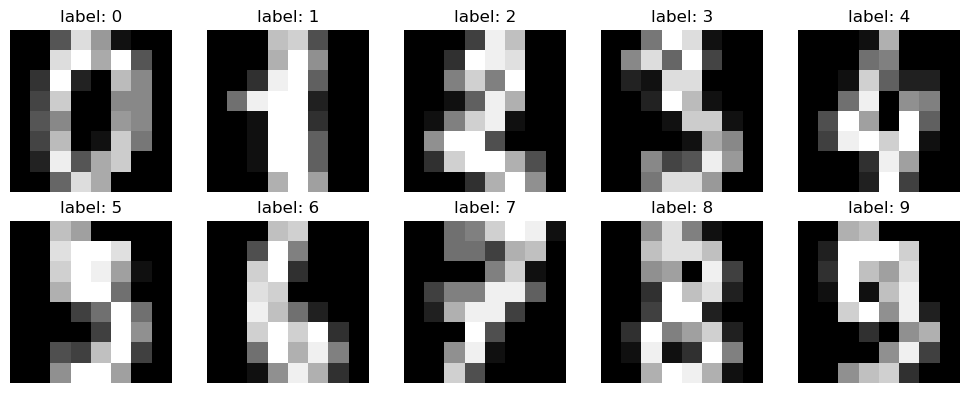

In [27]:
# *****************
# *** Your code ***
# *****************
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits=load_digits()

print(digits.keys()) #observe the keys of the dataset
print(f"data matrix shape: {digits.data.shape}")
print(f"data: {digits.data[:3]}...")

print(f"Target vector shape: {digits.target.shape}")
print(f"Target names: {digits.target_names}")
print(f"Target: {digits.target[:15]}...")

if digits.frame is None:
    print("frame: None")
else:
    print(f"frame shape: {digits.frame.shape}")

print(f"feature names: {digits.feature_names[:5]}...") #print the first 5 feature names

print(f"Image tensor shape: {digits.images.shape}")
# Visualize some of the digits
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, img, label in zip(axes.ravel(), digits.images[:10], digits.target[:10]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"label: {label}")
    ax.axis('off')
plt.tight_layout()

print(f"Description: {digits.DESCR}...") #print the first 193 characters of the description


### 练习 1.3
创建并训练（fit）一个 UMAP 降维器，然后对数据进行转换和可视化，例如可以按如下方式：


C:\Users\12627\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


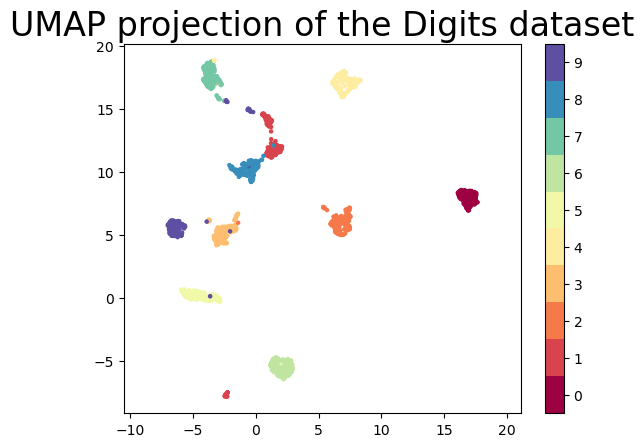

In [ ]:
########### Example code ###########
reducer = umap.UMAP(random_state=42) # Initialize UMAP reducer
reducer.fit(digits.data) # Fit UMAP on the digits data（64）
embedding = reducer.transform(digits.data) # Transform the data to 2D embedding

plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);



__请至少从概念层面准备好解释它在做什么__


# 练习 2
计算数据集中每个样本与各类别均值之间的余弦相似度（应在讲座 2 中介绍过），步骤如下：

### 练习 2.1
计算每个类别的“平均图像”，记为 ```mean_images```


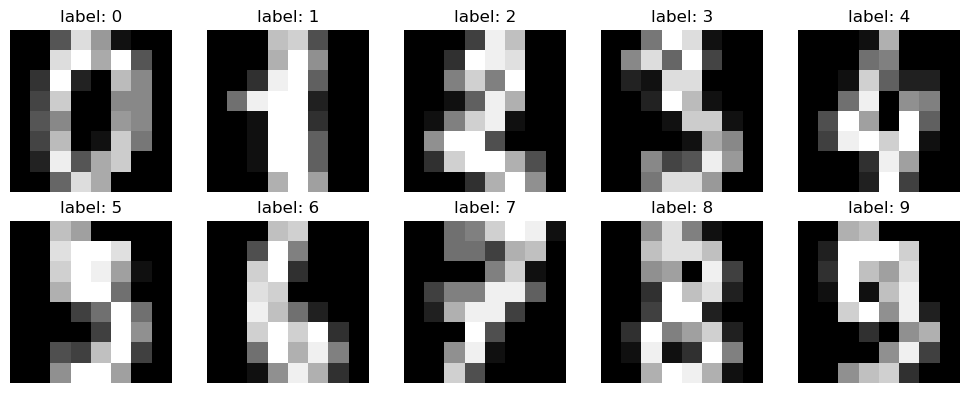

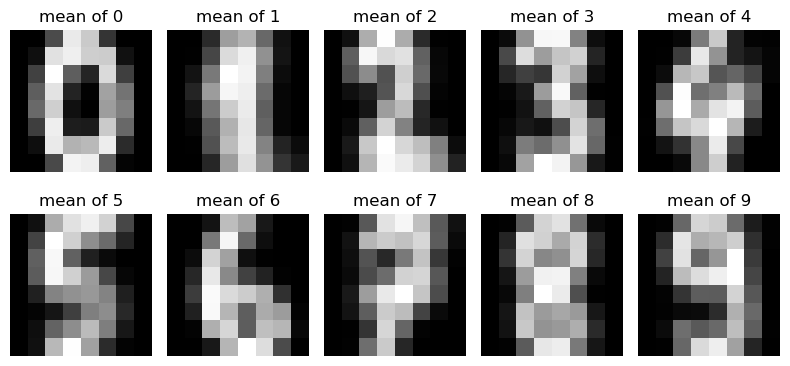

In [ ]:
# *****************
# *** Your code ***
# *****************
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
#original
# Visualize some of the digits
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, img, label in zip(axes.ravel(), digits.images[:10], digits.target[:10]):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"label: {label}")
    ax.axis('off')
plt.tight_layout()

#mean images
digits = load_digits()

mean_images = []  #calculate the mean image for each digit class（on target axis)
for digit in range(10):
    class_imgs = digits.images[digits.target == digit]
    mean_images.append(class_imgs.mean(axis=0))

fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for ax, mean_img, digit in zip(axes.ravel(), mean_images, range(10)):
    ax.imshow(mean_img, cmap='gray')
    ax.set_title(f"mean of {digit}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### 练习 2.2
分别计算原始数据的按行 L2 范数，即每幅图像的 L2 范数（可以查阅例如 Numpy 的 linalg.norm），__以及__ 上一步得到的平均图像的 L2 范数。


In [29]:
# *****************
# *** Your code ***
# *****************
import numpy as np

#original data L2 norm calculation
data_norms = np.linalg.norm(digits.data, axis=1)  # Compute the L2 norm for each sample
print("L2 norms of the first 10 samples:", data_norms[:10]) 

#mean image L2 norm calculation
mean_image_norms = np.linalg.norm(np.array(mean_images).reshape(10, -1), axis=1)
print("L2 norms of the mean images for each digit class:", mean_image_norms)




L2 norms of the first 10 samples: [55.40758071 64.87680633 66.24198065 54.34151268 55.4436651  66.73829485
 62.36986452 58.13776741 66.83561925 64.87680633]
L2 norms of the mean images for each digit class: [57.21007138 56.76243429 56.13686576 55.6744608  55.96995923 54.6351969
 57.73202669 54.9510358  57.26457834 54.64989411]


### 练习 2.3
计算归一化后的原始数据与平均图像矩阵之间的余弦相似度矩阵 ```similarities```。可参考 https://en.wikipedia.org/wiki/Cosine_similarity 了解公式。


In [69]:
# *****************
# *** Your code ***
# *****************
import numpy as np

#data and mean data
data=digits.data
means=np.array(mean_images).reshape(10, -1)

#L2 norms with keepdims=True
data_norms = np.linalg.norm(data, axis=1, keepdims=True)
mean_norms = np.linalg.norm(means, axis=1, keepdims=True)

#normalization
normalized_data = data / data_norms
normalized_means = means / mean_norms

#cos similarity calculation
similarities = normalized_data @ normalized_means.T  # shape: (1797, 10)
print("Cosine similarities shape:", similarities.shape)
print("Cosine similarities for the first 5 samples:\n", similarities[:5])

Cosine similarities shape: (1797, 10)
Cosine similarities for the first 5 samples:
 [[0.96953736 0.64057712 0.69033218 0.74642341 0.73680146 0.77826502
  0.73035169 0.69534056 0.78048386 0.82650128]
 [0.61422565 0.95983463 0.80485635 0.76387395 0.80925868 0.76271406
  0.7437892  0.77964591 0.85403808 0.73784076]
 [0.70985123 0.87401958 0.82590236 0.73522576 0.76270004 0.6699888
  0.7646454  0.77998321 0.85962083 0.72941315]
 [0.68640236 0.78536945 0.8189562  0.9174729  0.62058262 0.77934773
  0.72210824 0.65487293 0.79239528 0.83183922]
 [0.67283014 0.75460822 0.55884659 0.57641423 0.87062722 0.60938497
  0.75107912 0.61774954 0.69274152 0.61763855]]


### 练习 2.4
为每个类别绘制余弦相似度最高/最低的样本（图像），即距离最近和“最远”的样本，并同时显示对应的平均图像。你可以参考下面的绘图例程，以获取带元数据的图像输出（```similarities``` 是包含所有余弦相似度的矩阵）：


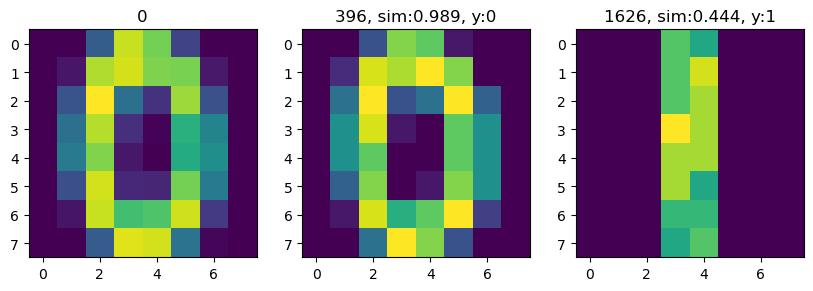

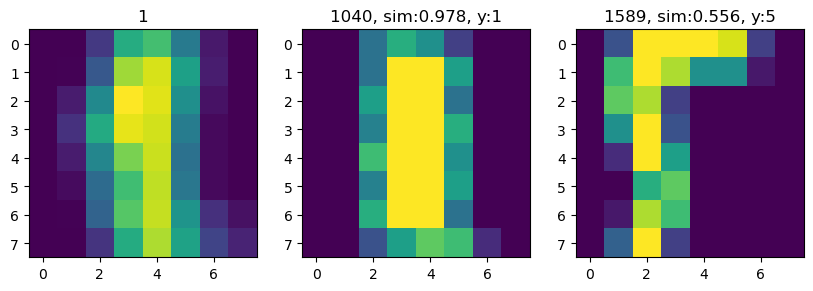

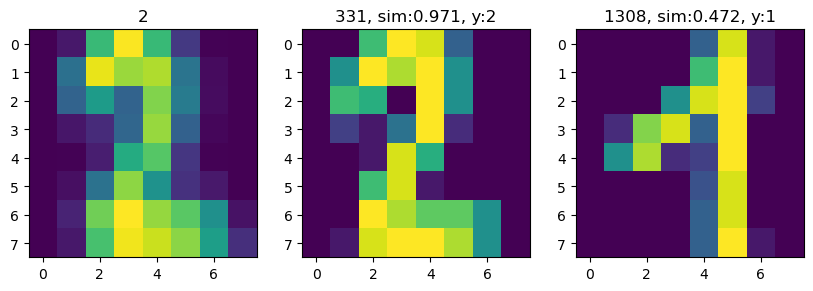

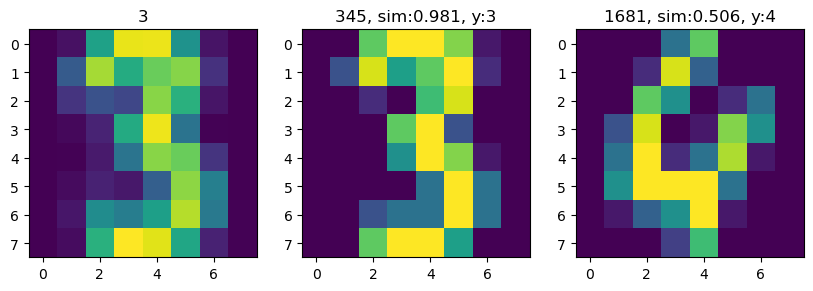

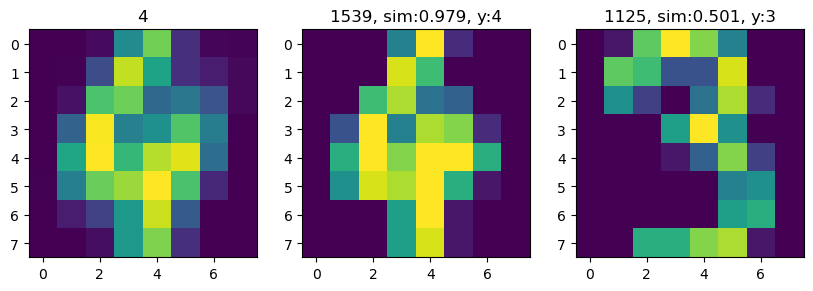

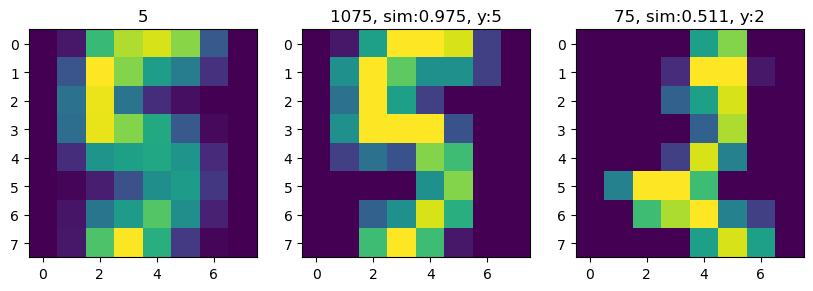

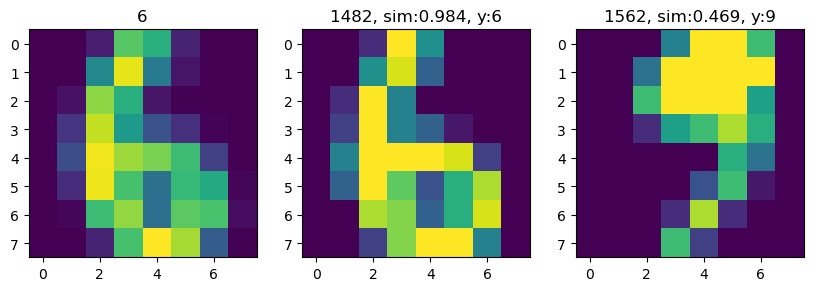

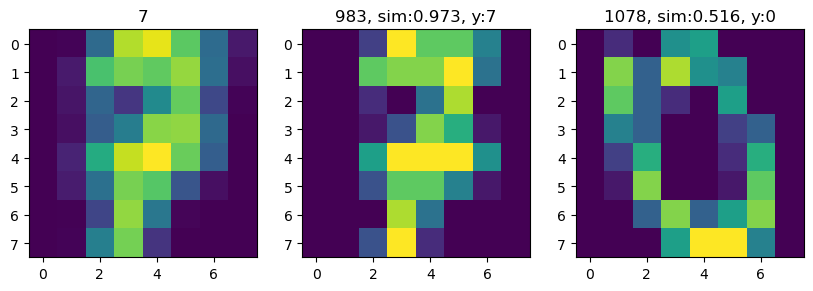

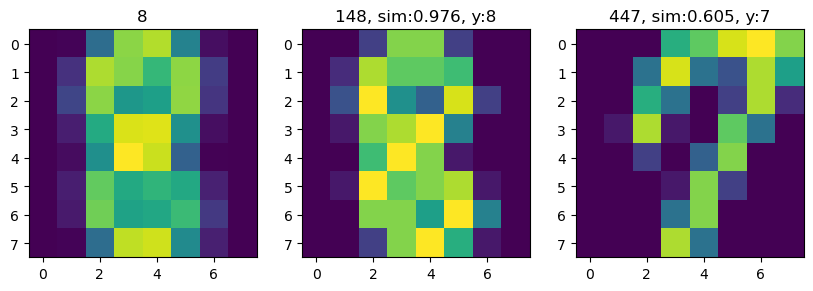

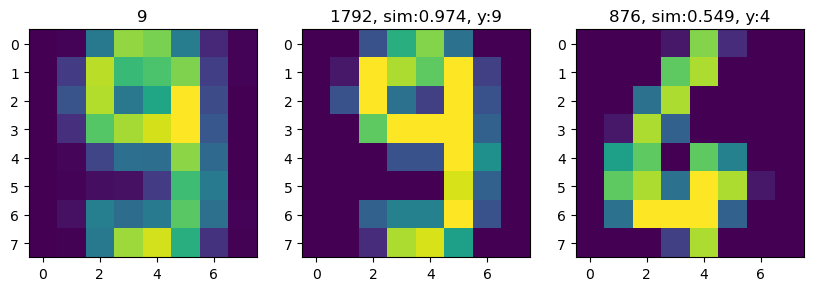

In [34]:
for i in range(0, 10):

    min_idx = np.argmin(similarities[:,i])
    max_idx = np.argmax(similarities[:,i])

    fig, axs = plt.subplots(1,3,figsize=(10,10))
    X = digits.data  # shape (1797, 64)
    
    # reference image
    axs[0].set_title(f"{i}")        
    axs[0].imshow(mean_images[i].reshape(8,8))
    
    # image and data with highest similarity to reference
    axs[1].set_title(f"{max_idx}, sim:{similarities[max_idx, i]:.3f}, y:{digits.target[max_idx]}")
    axs[1].imshow(X[max_idx].reshape(8,8))
    
    # image and data with lowest similarity to reference
    axs[2].set_title(f"{min_idx}, sim:{similarities[min_idx, i]:.3f}, y:{digits.target[min_idx]}")
    axs[2].imshow(X[min_idx].reshape(8,8))

plt.show()

__准备好解释__ 你所看到的内容，并进行反思！


# 练习 3
将数据集拆分为 70% 的训练数据（特征和标签）以及 30% 的测试数据（用于后续的分类器）。使用 ```sklearn.model_selection``` 中的 ```train_test_split``` 方法。设置 ```random_state=13``` 并在标签上使用 ```stratify```（确保测试集中各标签数量与整体一致）。


In [ ]:
# *****************
# *** Your code ***
# *****************
from sklearn.model_selection import train_test_split
#X means data, Y means target
X_train, X_test, y_train, y_test = train_test_split(
    digits.data,
    digits.target,
    test_size=0.3,
    random_state=13,
    stratify=digits.target
)

print(X_train.shape, X_test.shape)  # (1257, 64) (540, 64)
print(y_train.shape, y_test.shape)  # (1257,) (540,)

(1257, 64) (540, 64)
(1257,) (540,)


# 练习 4：k-NN
按如下方式使用 k-NN 分类器处理数据：

### 练习 4.1
使用 SciKitLearn 中默认的 ```sklearn.neighbors.KNeighborsClassifier```，设置 ```n_neighbors = 5, algorithm = 'brute'```，其他参数保持默认。


In [36]:
# *****************
# *** Your code ***
# *****************
from sklearn.neighbors import KNeighborsClassifier
#take the neareast 5 neighbors each time
#algorithm='brute': brute-force search over all training samples
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

### 练习 4.1
使用训练数据准备分类器（“拟合模型”），也就是执行类似以下操作


In [37]:
# *****************
# *** Your code ***
# *****************
# fit stores the training data so nearest-neighbor queries can run later
knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'brute'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### 练习 4.2
将分类器应用于测试数据，即通过以下方式获取测试数据的预测结果


In [38]:
# *****************
# *** Your code ***
# *****************
# predict labels for the held-out test set
y_pred = knn.predict(X_test)

为每个测试样本获取在训练集中最近的邻居及其对应距离，可以使用


In [39]:
#Usage <distances, neighbors> = <classifier>.kneighbors( <test_features>) 

# *** Your code ***
distances, neighbors = knn.kneighbors(X_test)
print(f"Nearest-neighbor indices for the first test sample: {neighbors[0]}, distances: {distances[0]}")

Nearest-neighbor indices for the first test sample: [874 812 218 519 554], distances: [26.45751311 27.16615541 28.14249456 28.14249456 28.23118843]


为部分测试图像可视化其 5 个最近邻（参见教程！）


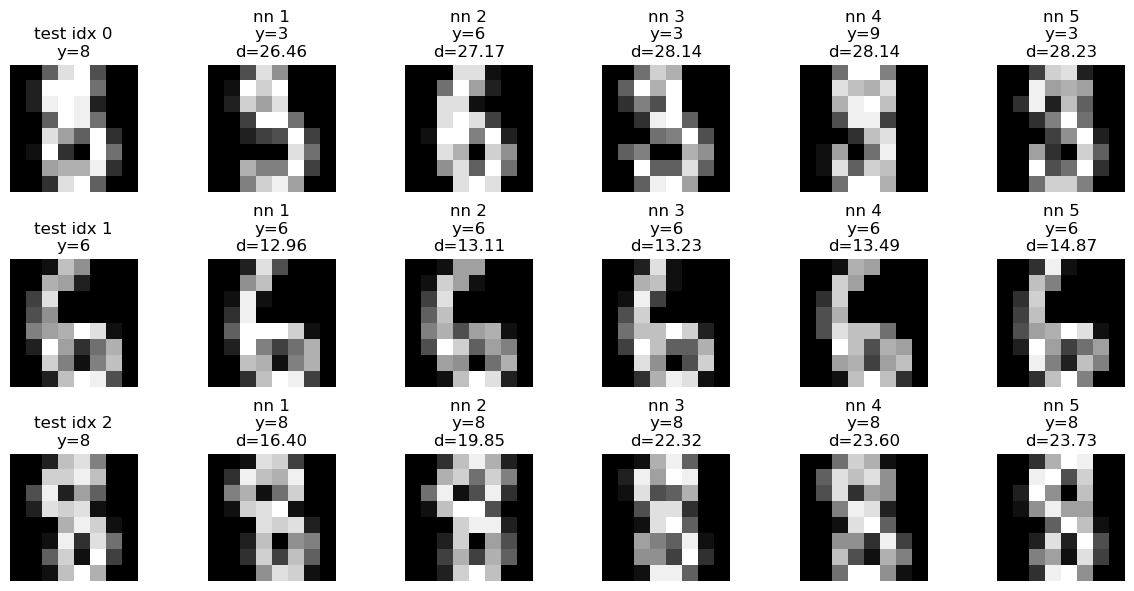

In [44]:
# *****************
# *** Your code ***
# *****************
# visualize the 5 nearest neighbors for a few test samples
num_examples = 3  # change to display more/less
fig, axes = plt.subplots(num_examples, 6, figsize=(12, 6))

for row in range(num_examples):
    test_idx = row  # take the first few test samples; pick any index you like
    # column 0: the test image itself
    axes[row, 0].imshow(X_test[test_idx].reshape(8, 8), cmap='gray')
    axes[row, 0].set_title(f"test idx {test_idx}\ny={y_test[test_idx]}")
    axes[row, 0].axis('off')

    # columns 1-5: its five nearest neighbors from the training set
    for col, (neighbor_idx, dist) in enumerate(zip(neighbors[test_idx], distances[test_idx]), start=1):
        axes[row, col].imshow(X_train[neighbor_idx].reshape(8, 8), cmap='gray')
        axes[row, col].set_title(f"nn {col}\ny={y_train[neighbor_idx]}\nd={dist:.2f}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()
        

### 练习 4.3
使用 sklearn.metrics 提供的 classification_report 和 confusion_matrix 对分类器进行评估：


In [47]:
# Usage metrics.classification_report( <test_labels>, <predicted_labels>) 
# *****************
# *** Your code ***
# *****************
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report:")
print(classification_report(y_test, y_pred))



Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.96      1.00      0.98        55
           2       0.98      0.98      0.98        53
           3       0.98      0.96      0.97        55
           4       1.00      0.98      0.99        54
           5       0.98      1.00      0.99        55
           6       1.00      1.00      1.00        54
           7       0.98      1.00      0.99        54
           8       0.96      0.94      0.95        52
           9       1.00      0.98      0.99        54

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



以及


In [48]:
# USage metrics.confusion_matrix( <test_labels, <predicted_labels>)
# *****************
# *** Your code ***
# *****************
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  1  0  0]
 [ 0  0  1 53  0  1  0  0  0  0]
 [ 0  0  0  0 53  0  0  0  1  0]
 [ 0  0  0  0  0 55  0  0  0  0]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  2  0  1  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  1 53]]


# 练习 5：k-Means
按如下方式使用 k-Means 对数据进行聚类：


### 练习 5.1
创建一个 k-Means 实例（```sklearn.cluster.KMeans```），设置 ```n_clusters=10```、```n_init=100``` 和 ```random_state=42```。


In [51]:
#*** Your code ***
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=100, random_state=42)  # 10 clusters, run 100 initializations

### 练习 5.2
使用以下方式运行聚类：


In [70]:
#<clusters> = <clustering>.fit(<train_features>)
# *** Your code ***
clusters = kmeans.fit(X_train)

### 练习 5.3
可视化得到的聚类中心（可以通过 <clustering>.cluster_centers_ 获取）；这些原则上也是图像，但可能不像你希望的那样易于解读。将看到的内容与 UMAP 散点图进行比较，也就是说，尝试找到在 UMAP 图中明显彼此区分的 k-Means 聚类（聚类中心可视化为图像）以及那些看起来“都差不多”或至少非常接近的簇（在 UMAP 图中可视化为斑点或散点）。


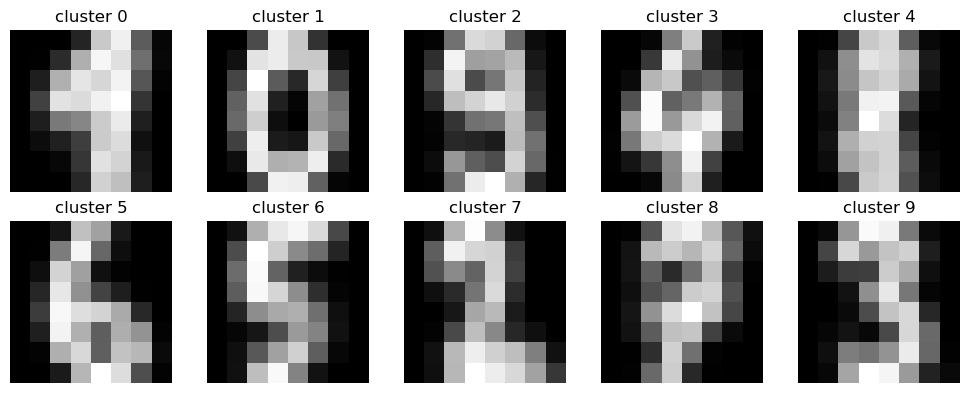

C:\Users\12627\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


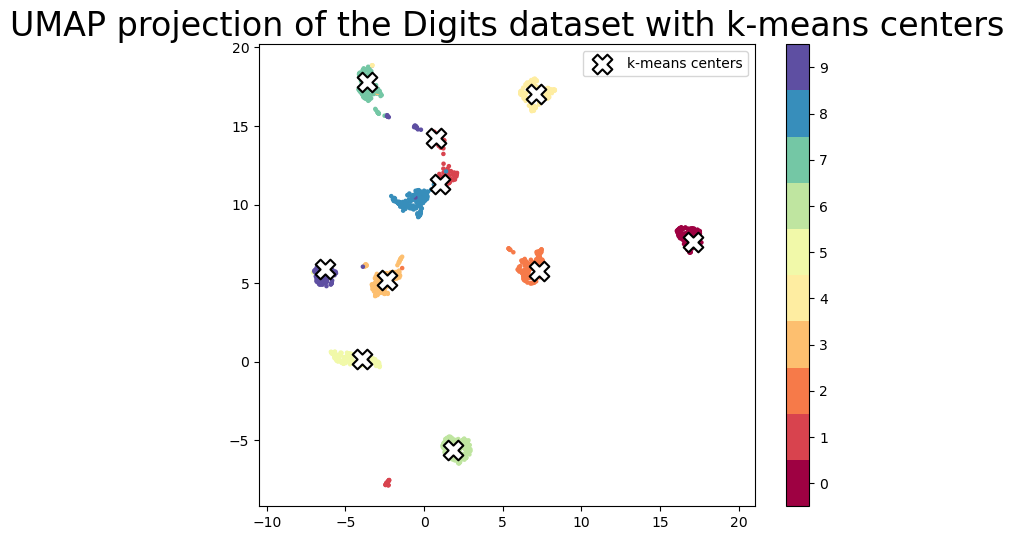

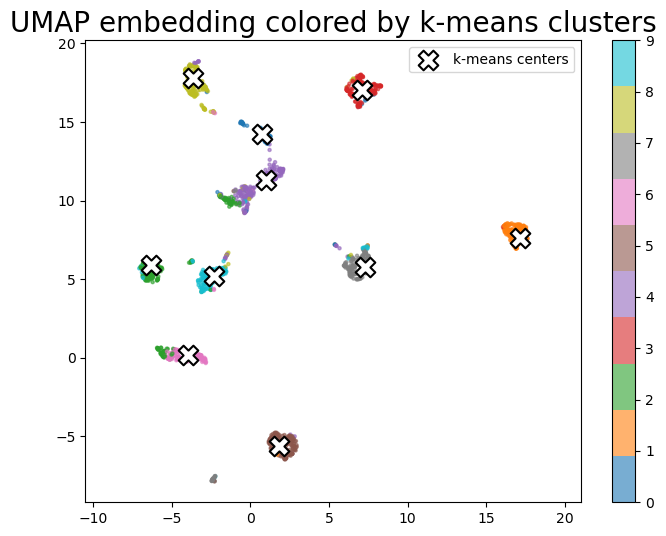

In [60]:
# *****************
# *** Your code ***
# *****************
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, center, idx in zip(axes.ravel(), centers, range(10)):
    ax.imshow(center, cmap='gray')
    ax.set_title(f"cluster {idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# plot UMAP embedding with k-means cluster centers
reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)
embedding = reducer.transform(digits.data)

cluster_embedding = reducer.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
points = plt.scatter(embedding[:, 0], embedding[:, 1],
                     c=digits.target, cmap='Spectral', s=5)
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1],
            marker='X', s=200, linewidth=1.5,
            facecolors='white', edgecolors='black', label='k-means centers')

plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(points, boundaries=np.arange(11) - 0.5)
cbar.set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset with k-means centers', fontsize=24)
plt.legend(loc='upper right')
plt.show()

cluster_labels = kmeans.predict(digits.data)  # 或者用 kmeans.labels_ 看训练集
cluster_embedding = reducer.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
centroid_scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                               c=cluster_labels, cmap='tab10', s=5, alpha=0.6)
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1],
            marker='X', s=200, linewidth=1.5,
            facecolors='white', edgecolors='black', label='k-means centers')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(centroid_scatter, ticks=range(10))
plt.title('UMAP embedding colored by k-means clusters', fontsize=20)
plt.legend(loc='upper right')
plt.show()

### 练习 5.4
查阅 SciKitLearn 文档中的以下评估工具：```metrics.completeness_score( <labels>, <cluster-labels>)``` 与 ```metrics.homogeneity_score( <labels>, <cluster-labels>)```


为了让这些指标可用，你需要对训练数据运行一次预测步骤（得到聚类标签）。大致的指标参考值可以在下方的检查清单中找到。


In [ ]:
# *****************
# *** Your code ***
# *****************
from sklearn.metrics import completeness_score, homogeneity_score

train_cluster_labels = kmeans.labels_  # cluster assignments for X_train
#how much of each gold class is captured inside a single cluster 
comp = completeness_score(y_train, train_cluster_labels)
#how “pure” each cluster is with respect to the gold labels
homo = homogeneity_score(y_train, train_cluster_labels)

print(f"Completeness score: {comp:.4f}")
print(f"Homogeneity score: {homo:.4f}")




Completeness score: 0.7576
Homogeneity score: 0.7491


感兴趣的话，可尝试以下指标（核心概念是互信息分数，调整互信息分数是其改进版本），阅读其文档、与伙伴讨论并在同伴评审中分享想法（在信息论课程之后会更好理解，但它也包含一些可以先行思考的直观含义）


In [63]:
# Usage metrics.adjusted_mutual_info_score( <labels>, <cluster-labels>)
# *****************
# *** Your code ***
# *****************
from sklearn.metrics import adjusted_mutual_info_score
# Adjusted Mutual Information(AMI) between true labels and k-means clusters
# how much information the cluster assignments and the true labels share, after correcting for agreement that could happen purely by chance
ami = adjusted_mutual_info_score(y_train, kmeans.labels_)  
print(f"Adjusted mutual information: {ami:.4f}")

Adjusted mutual information: 0.7498


### 练习 5.5
对于每个聚类，通过选取该聚类中训练数据出现次数最多的标签为其指派一个标签。


In [ ]:
# *****************
# *** Your code ***
# *****************
# Assign labels to clusters. 
import numpy as np

cluster_labels = kmeans.labels_  # cluster assignment for each training sample
cluster_to_digit = {}

for cluster_id in range(kmeans.n_clusters):
    members = y_train[cluster_labels == cluster_id] #bool array indicates whether the cluster has the correct lable
    if len(members) == 0:
        cluster_to_digit[cluster_id] = None  # empty cluster (should not happen here)
    else:
        majority_label = np.bincount(members).argmax()
        cluster_to_digit[cluster_id] = majority_label

print("Most common training digit per cluster:")
for cid, label in cluster_to_digit.items():
    print(f"cluster {cid} → digit {label}")


Most common training digit per cluster:
cluster 0 → digit 1
cluster 1 → digit 0
cluster 2 → digit 9
cluster 3 → digit 4
cluster 4 → digit 8
cluster 5 → digit 6
cluster 6 → digit 5
cluster 7 → digit 2
cluster 8 → digit 7
cluster 9 → digit 3


### 练习 5.6
使用上一题中的聚类结果对测试数据进行预测并评估结果。它的表现会非常差。


In [67]:
# *****************
# *** Your code ***
# *****************
# Predict on the test set

test_clusters = kmeans.predict(X_test)
cluster_preds = np.array([cluster_to_digit[c] for c in test_clusters])

print("Classification report:")
print(classification_report(y_test, cluster_preds))

cm_cluster = confusion_matrix(y_test, cluster_preds)
print("Confusion matrix:\n", cm_cluster)

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.73      0.35      0.47        55
           2       0.83      0.81      0.82        53
           3       0.87      0.82      0.84        55
           4       0.98      0.87      0.92        54
           5       0.86      0.76      0.81        55
           6       1.00      0.98      0.99        54
           7       0.83      0.96      0.89        54
           8       0.43      0.50      0.46        52
           9       0.57      0.87      0.69        54

    accuracy                           0.79       540
   macro avg       0.81      0.79      0.79       540
weighted avg       0.81      0.79      0.79       540

Confusion matrix:
 [[53  0  0  0  1  0  0  0  0  0]
 [ 0 19  7  0  0  1  0  0 28  0]
 [ 1  0 43  3  0  0  0  3  3  0]
 [ 0  0  1 45  0  2  0  2  0  5]
 [ 0  4  0  0 47  0  0  1  2  0]
 [ 0  0  0  1  0 42  0  0  0 12]
 